Давайте подивимося, як LSTM можна використовувати для побудови нейронної мережі прогнозування часових.

Будемо працювати з задачею прогнозування кількості пасажирів міжнародних авіаліній. З цим набором даних ми вже працювали в лекції "Time Series Analysis" і ви зможете порівняти результати :)

Задача полягає в тому, щоб за заданими роком і місяцем передбачити кількість пасажирів міжнародних авіаліній в одиницях виміру 1,000. Дані охоплюють період з січня 1949 року по грудень 1960 року, тобто 12 років, зі 144 спостереженнями.

Це регресійна задача. Тобто, знаючи кількість пасажирів (в тисячах) за останні місяці, можна передбачити, якою буде кількість пасажирів у наступному місяці. Набір даних має лише одну характеристику: "Кількість пасажирів" - `Passengers`.

Далі вже наведений код для читання даних, але нам їх ще треба буде трошки обробити.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Завантаження даних
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url)
df.set_index('Month', inplace=True)
display(df.head())

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


**Завдання 1.** Створіть змінну типу `numpy.ndarray`, яка містить значення кількості пасажирів в форматі `float32`. Такий формат даних нам треба для тренування нейромережі.

In [2]:
# Витягуємо стовпець Passengers і перетворюємо в numpy-масив із потрібним типом
passenger_data = df['Passengers'].values.astype(np.float32)

# Перевіримо результат
print(type(passenger_data))    # <class 'numpy.ndarray'>
print(passenger_data.dtype)    # float32
print(passenger_data.shape)    # (144,)

<class 'numpy.ndarray'>
float32
(144,)


Очікуваний результат:
```array([112., 118., 132., 129., 121.], dtype=float32)```

**Завдання 2**. Розбийте дані на тренувальні і валідаційні у співвідношенні 67% йде у тренування, 33 - у валідацію. Памʼятаємо, що ми працюємо з tim series, відповідно, навчаємось на давніших, валідуємось - на новіших.

In [3]:
# Загальна довжина даних
n_total = passenger_data.shape[0]  # 144

# Обчислюємо розмір тренувальної вибірки (67%)
n_train = int(n_total * 0.67)      # int(144 * 0.67) = 96

# Розбиваємо: перші 96 — тренувальні, решта 48 — валідаційні
train_data = passenger_data[:n_train]
val_data   = passenger_data[n_train:]

# Перевіримо розміри та перші значення
print(train_data.shape)  # (96,)
print(val_data.shape)    # (48,)
print(train_data[:5])    # перші 5 значень тренувальної
print(val_data[:5])      # перші 5 значень валідаційної

(96,)
(48,)
[112. 118. 132. 129. 121.]
[315. 301. 356. 348. 355.]


**Завдання 3**.

Реалізуйте функцію `create_dataset`, яка перетворить одномірний часовий ряд (набір даних) у формат, придатний для тренування нейромережі.

Функція повинна приймати два аргументи:
- `dataset` — numpy-масив часового ряду,
- `lookback` — кількість попередніх кроків, які використовуватимуться для передбачення.

Функція повинна повернути два **тензори** PyTorch:
- `X` — набір ознак (вікно попередніх значень),
- `y` — цільові значення (наступні після вікна кроки).

Дані ми будемо подавати моделі в наступному форматі:
`
tensor([[112.],
        [118.],
        [132.],
        [129.],
        [121.]])
`
Відповідно першою розмірністю буде йти розмір вхідного батча, а другою - розмір вхіднизх даних і в нас це 1, бо лише одне значення на вході щоразу.

Після виконання завдання запустіть код нижче. Ми будемо передбачати на основі кількості пасажирів в попередній день кількість пасажирів в наступний, тому `lookback == 1`.

In [4]:
import torch

def create_dataset(dataset: np.ndarray, lookback: int):
    """
    Перетворює одномірний часовий ряд у X, y для тренування NN.

    Args:
        dataset (np.ndarray): одномірний масив даних.
        lookback (int): кількість попередніх кроків для вікна.

    Returns:
        X (torch.Tensor): тензор розмірності (N-lookback, lookback, 1)
        y (torch.Tensor): тензор розмірності (N-lookback, 1)
    """
    X, y = [], []
    for i in range(len(dataset) - lookback):
        window = dataset[i:(i + lookback)]
        target = dataset[i + lookback]
        X.append(window)
        y.append(target)
    # перетворюємо списки у numpy-масиви, потім у тензори
    X = np.array(X, dtype=np.float32).reshape(-1, lookback, 1)
    y = np.array(y, dtype=np.float32).reshape(-1, 1)
    return torch.from_numpy(X), torch.from_numpy(y)

# Приклад використання для lookback = 1:
X_train, y_train = create_dataset(train_data, lookback=1)
print(X_train.shape)  # очікуємо (95, 1, 1)
print(y_train.shape)  # очікуємо (95, 1)
print(X_train[:5])    # перші 5 вікон
print(y_train[:5])    # перші 5 цілей

torch.Size([95, 1, 1])
torch.Size([95, 1])
tensor([[[112.]],

        [[118.]],

        [[132.]],

        [[129.]],

        [[121.]]])
tensor([[118.],
        [132.],
        [129.],
        [121.],
        [135.]])


In [7]:
lookback = 1
X_train, y_train = create_dataset(train_data, lookback=lookback)
X_test, y_test = create_dataset(val_data, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([95, 1, 1]) torch.Size([95, 1])
torch.Size([47, 1, 1]) torch.Size([47, 1])


Очікуваний результат:
```
torch.Size([95, 1]) torch.Size([95, 1])
torch.Size([47, 1]) torch.Size([47, 1])
```

**Завдання 4**.

Зверніть увагу на розмірності в попередньому завданні. Ми
З допомогою модуля `torch.nn` опишіть клас `AirModel`, який є нейронною мережею для прогнозування кількості пасажирів за допомогою LSTM.

1. **Конструктор класу** повинен приймати параметри `hidden_size`, `num_layers` та ініціювати шари:
   - LSTM-шар з наступними параметрами:
     - `input_size` — кожна точка часового ряду є окремим входом,,
     - `hidden_size` — заданий в конструкторі класу мережі,
     - `num_layers=1` — кількість шарів LSTM, задана в конструкторі мережі,
     - `batch_first=True` — визначає, що першим виміром є розмір батчу.
   - Лінійний шар (`nn.Linear`) для перетворення виходу LSTM на прогноз однієї точки.

2. **Метод forward** повинен виконувати наступні дії:
   - Передати вхідний тензор через LSTM-шар і отримати виходи (ігноруючи приховані стани).
   - Пропустити вихід LSTM через лінійний шар для отримання остаточного прогнозу.

Створіть об'єкт класу `AirModel` зі значеннями параметрів `hidden_size=50`, `num_layers=1` і протестуйте роботу моделі на вхідному тензорі `tensor([[112.]])`. На цьому етапі ми маємо переконатись, що модель здатна генерувати передбачення з рандомно ініційованими вагами.

In [8]:
import torch
import torch.nn as nn

# Визначення моделі
class AirModel(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super(AirModel, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        last_time_step = out[:, -1, :]
        y_pred = self.linear(last_time_step)
        return y_pred

# Створюємо модель та тестовий вхід
model = AirModel(hidden_size=50, num_layers=1)
test_input = torch.tensor([[112.]], dtype=torch.float32).unsqueeze(-1)  # (1,1,1)

# Робимо передбачення
output = model(test_input)

print("Вхід:", test_input)
print("Вихід моделі:", output)

Вхід: tensor([[[112.]]])
Вихід моделі: tensor([[-0.1197]], grad_fn=<AddmmBackward0>)


**Завдання 5**.

Створіть об'єкт DataLoader для завантаження даних, використовуючи тренувальні вибірки `X_train` та `y_train`. Ваш DataLoader повинен виконувати наступні вимоги:

1. Використовувати клас `TensorDataset`, щоб об'єднати тензори ознак `X_train` і цільових значень `y_train`.
2. Дані повинні завантажуватися невеликими батчами розміром 8 за допомогою параметра `batch_size`.
3. Використовувати параметр `shuffle=True`, щоб дані перемішувалися перед кожною епохою тренування.


In [9]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Припускаємо, що X_train, y_train вже визначені як тензори
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

print(f"Кількість батчів у train_loader: {len(train_loader)}")
for X_batch, y_batch in train_loader:
    print("X_batch.shape:", X_batch.shape)
    print("y_batch.shape:", y_batch.shape)
    break

Кількість батчів у train_loader: 12
X_batch.shape: torch.Size([8, 1, 1])
y_batch.shape: torch.Size([8, 1])


**Завдання 6**.

1. Реалізуйте навчання нейронної мережі `AirModel` для прогнозування часових рядів, використовуючи Adam-оптимізатор та функцію втрат MSE (середньоквадратичну похибку).
2. Створіть цикл тренування для 2000 епох, у якому на кожній епосі:
   - Виконуйте крок тренування моделі (прямий прохід, обчислення похибки, зворотний прохід і оновлення ваг).
   - Підраховуйте середню похибку на кожному батчі даних і зберігайте її у списку `losses`.
3. Раз на 100 епох проводьте валідацію моделі:
   - Перевіряйте модель на тренувальних та тестових даних без оновлення ваг.
   - Обчислюйте корінь середньоквадратичної похибки (RMSE) для тренувальної та тестової вибірок і виводьте результати на екран.
   
**Примітка:**
- Використовуйте вже створений `DataLoader` для отримання батчів даних.
- Валідацію виконуйте в режимі `eval()`, вимикаючи обчислення градієнтів з `torch.no_grad()`.

**Приклад виходу:**
```
Epoch 0: train RMSE 12.3456, test RMSE 15.6789
Epoch 100: train RMSE 9.8765, test RMSE 12.3456
...
```

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 1. Створюємо DataLoader для тестових даних
test_dataset = TensorDataset(X_test, y_test)
test_loader  = DataLoader(test_dataset, batch_size=8, shuffle=False)

# 2. Визначаємо оптимізатор і функцію втрат
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn   = nn.MSELoss()

losses = []  # тут будемо зберігати середню втрату по батчах кожної епохи

# 3. Цикл тренування
for epoch in range(1, 2001):
    model.train()
    epoch_loss = 0.0

    for Xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(Xb)              # прямий прохід
        loss  = loss_fn(preds, yb)     # обчислення MSE
        loss.backward()                # зворотний прохід
        optimizer.step()               # оновлення ваг

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)

    # 4. Валідація раз на 100 епох
    if epoch % 100 == 0:
        model.eval()
        with torch.no_grad():
            # RMSE на тренувальному наборі
            train_preds = model(X_train)
            train_rmse  = torch.sqrt(loss_fn(train_preds, y_train))
            # RMSE на тестовому наборі
            test_preds  = model(X_test)
            test_rmse   = torch.sqrt(loss_fn(test_preds, y_test))

        print(f"Epoch {epoch:4d} — Train RMSE: {train_rmse:.4f},  Test RMSE: {test_rmse:.4f}")

Epoch  100 — Train RMSE: 191.6624,  Test RMSE: 386.5379
Epoch  200 — Train RMSE: 162.3885,  Test RMSE: 355.2447
Epoch  300 — Train RMSE: 136.1955,  Test RMSE: 326.1828
Epoch  400 — Train RMSE: 113.3689,  Test RMSE: 299.1754
Epoch  500 — Train RMSE: 94.7249,  Test RMSE: 274.4372
Epoch  600 — Train RMSE: 78.6004,  Test RMSE: 251.2319
Epoch  700 — Train RMSE: 64.5887,  Test RMSE: 228.8806
Epoch  800 — Train RMSE: 53.3925,  Test RMSE: 208.2846
Epoch  900 — Train RMSE: 44.5460,  Test RMSE: 189.6092
Epoch 1000 — Train RMSE: 38.0465,  Test RMSE: 172.7953
Epoch 1100 — Train RMSE: 33.1143,  Test RMSE: 158.1679
Epoch 1200 — Train RMSE: 30.9874,  Test RMSE: 146.0915
Epoch 1300 — Train RMSE: 28.1855,  Test RMSE: 135.3097
Epoch 1400 — Train RMSE: 28.0411,  Test RMSE: 128.0372
Epoch 1500 — Train RMSE: 26.3883,  Test RMSE: 120.4173
Epoch 1600 — Train RMSE: 28.0999,  Test RMSE: 114.9285
Epoch 1700 — Train RMSE: 24.3683,  Test RMSE: 111.3211
Epoch 1800 — Train RMSE: 24.0945,  Test RMSE: 108.5478
Epoch 

**Завдання 7.** Побудуйте графік лосів. Зробіть висновок з графіку, чи навчилась модель?

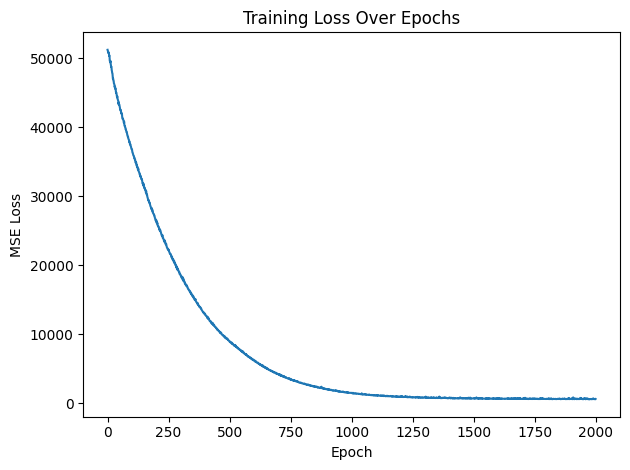

In [11]:
plt.figure()
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss Over Epochs')
plt.tight_layout()
plt.show()

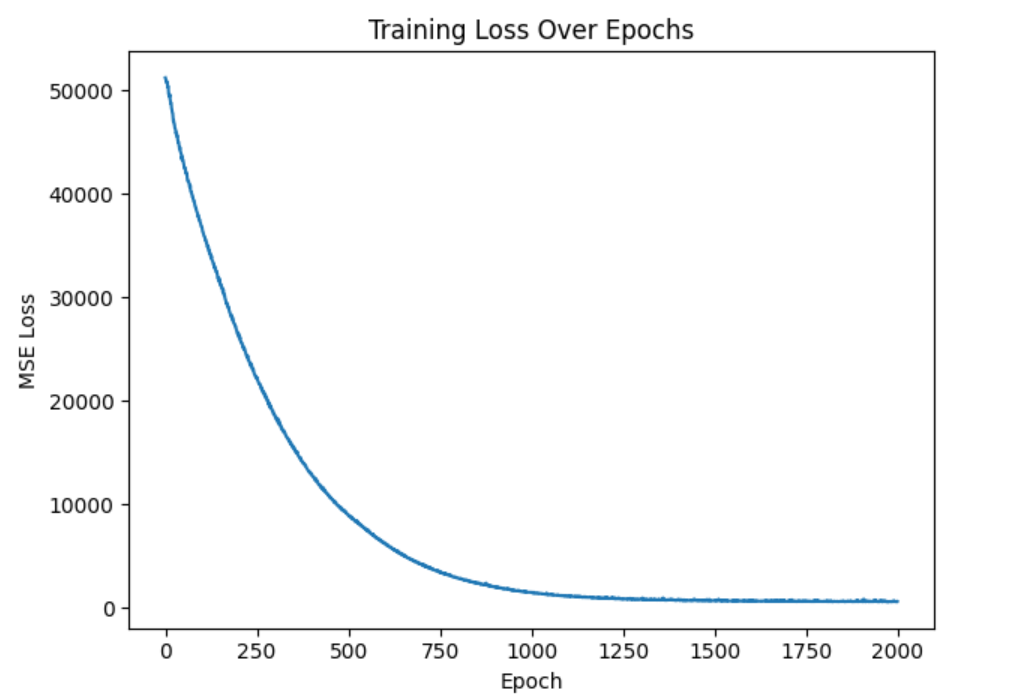

Модель навчилась, але не факт, що точно)

Доволі неочікувано, що середньоквадратичне відхилення тестового набору даних буде на порядок більшим за одиниці в нашому наборі даних. Середньоквадратичне відхилення 100 означає, що прогноз і фактичне значення будуть відрізнятися в середньому на 100 (тобто, 100 000 пасажирів у цьому наборі даних).



Щоб краще зрозуміти якість прогнозу, ви можете побудувати графік з кодом нижче (а ще нижче - описано, що відбувається в цьому коді, бо це теж корисно зрозуміти):

<ipython-input-13-8be886255d1e>:11: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_plot[lookback:train_size] = model(X_train)[:, -1]
<ipython-input-13-8be886255d1e>:15: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1]


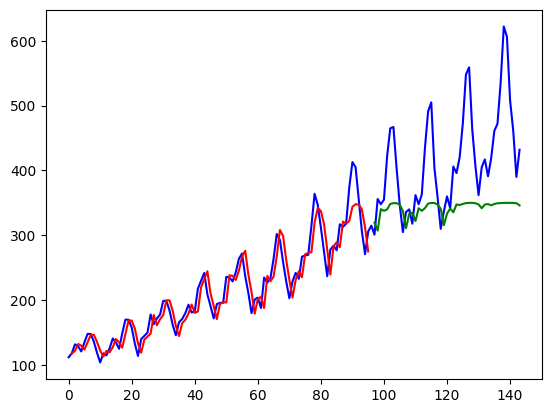

In [13]:
timeseries = passenger_data                       # довжина 144
train_size = len(train_data)                      # 96
lookback   = 1

def plot_predicts():
  with torch.no_grad():
      # Зсув прогнозів для тренувальних даних
      train_plot = np.ones_like(timeseries) * np.nan
      y_pred = model(X_train)
      y_pred = y_pred[:, -1]
      train_plot[lookback:train_size] = model(X_train)[:, -1]

      # Зсув прогнозів для тестових даних
      test_plot = np.ones_like(timeseries) * np.nan
      test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1]

  # Візуалізація результатів
  plt.plot(timeseries, c='b')  # Реальні дані
  plt.plot(train_plot, c='r')  # Прогнози на тренувальних даних
  plt.plot(test_plot, c='g')   # Прогнози на тестових даних
  plt.show()

plot_predicts()

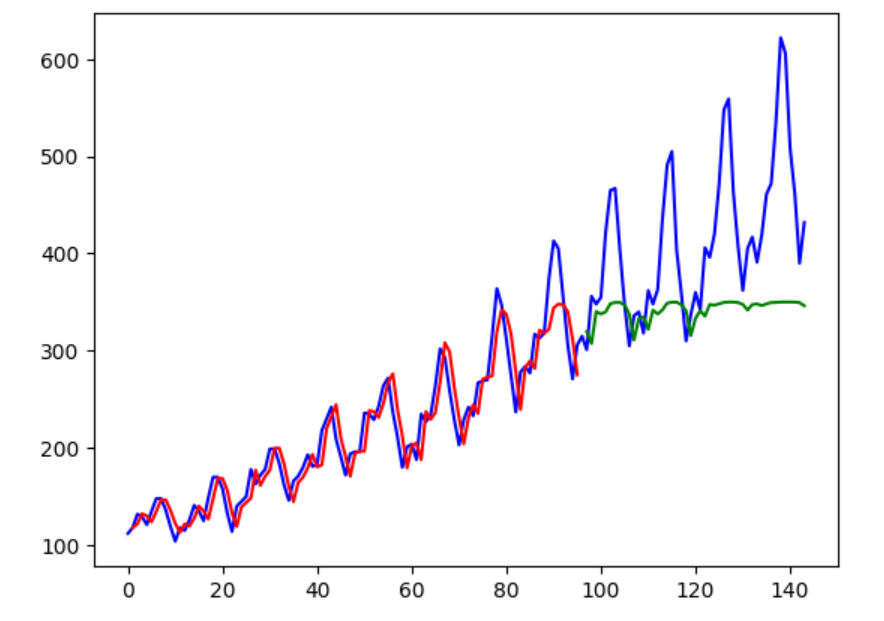

**Що відбувається в коді вище.** В цьому коді здійснюється процес прогнозування часових рядів за допомогою LSTM моделі, а також виведення графіку, який показує реальні значення, тренувальні та тестові прогнози. Ось що відбувається на кожному етапі:

1. **`torch.no_grad()`**: Цей контекстний менеджер вимикає обчислення градієнтів, що означає, що під час прогнозування не будуть зберігатися проміжні обчислення для зворотного проходу (backpropagation). Це підвищує ефективність під час прогнозування і зменшує використання пам'яті.

2. **Зсув прогнозів для тренувальних даних:**
   - Створюється масив `train_plot`, який має такий самий розмір, як і часовий ряд (`timeseries`), і заповнюється значеннями NaN (`np.nan`), щоб залишити місце для реальних значень.
   - Модель передбачає виходи для тренувальних даних `X_train`.
   - Використовується лише останнє передбачене значення для кожного входу LSTM (`y_pred[:, -1]`).
   - Прогнози зсуваються, починаючи з індексу `lookback` до кінця тренувальних даних (індекс `train_size`). Цей зсув потрібен, щоб зробити прогноз на основі попередніх даних і відобразити його на правильній частині графіку.

3. **Зсув прогнозів для тестових даних:**
   - Створюється масив `test_plot`, який також заповнюється NaN.
   - Прогнози для тестових даних додаються з індексу `train_size + lookback` до кінця реальних даних, щоб відобразити, де модель починає прогнозувати тестову вибірку.

4. **Побудова графіка:**
   - `plt.plot(timeseries, c='b')`: Виводить реальні значення часового ряду (синя лінія).
   - `plt.plot(train_plot, c='r')`: Виводить тренувальні прогнози (червона лінія).
   - `plt.plot(test_plot, c='g')`: Виводить тестові прогнози (зелена лінія).

**Чому це робиться:**
- Зсув прогнозів для тренувальних і тестових даних дозволяє візуально зрівняти, наскільки добре модель прогнозує як на тренувальній, так і на тестовій вибірках. Зазвичай, червона лінія (тренувальні прогнози) повинна точно відповідати синій лінії (реальні дані), а зелена лінія (тестові прогнози) дає змогу побачити, наскільки модель добре працює на нових даних, яких вона раніше не бачила.

**Завдання 8**. Навчіть модель з hidden_size=100 та порівняйте результати прогнозів з попередніми.

[h=50] Epoch  100 — Train RMSE: 188.69, Test RMSE: 383.40
[h=50] Epoch  200 — Train RMSE: 156.65, Test RMSE: 348.98
[h=50] Epoch  300 — Train RMSE: 128.60, Test RMSE: 317.43
[h=50] Epoch  400 — Train RMSE: 104.45, Test RMSE: 287.80
[h=50] Epoch  500 — Train RMSE: 85.80, Test RMSE: 261.65
[h=50] Epoch  600 — Train RMSE: 69.29, Test RMSE: 236.69
[h=50] Epoch  700 — Train RMSE: 56.14, Test RMSE: 213.51
[h=50] Epoch  800 — Train RMSE: 45.96, Test RMSE: 192.76
[h=50] Epoch  900 — Train RMSE: 38.37, Test RMSE: 174.14
[h=50] Epoch 1000 — Train RMSE: 33.73, Test RMSE: 158.21
[h=50] Epoch 1100 — Train RMSE: 29.97, Test RMSE: 144.78
[h=50] Epoch 1200 — Train RMSE: 27.54, Test RMSE: 133.55
[h=50] Epoch 1300 — Train RMSE: 26.63, Test RMSE: 125.67
[h=50] Epoch 1400 — Train RMSE: 25.97, Test RMSE: 119.04
[h=50] Epoch 1500 — Train RMSE: 24.77, Test RMSE: 112.64
[h=50] Epoch 1600 — Train RMSE: 24.71, Test RMSE: 108.54
[h=50] Epoch 1700 — Train RMSE: 24.04, Test RMSE: 106.18
[h=50] Epoch 1800 — Train R

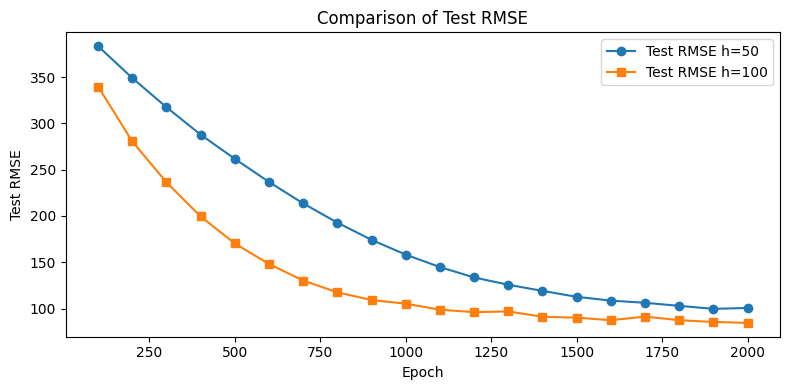

In [14]:
# Підготовка DataLoader'ів (припускаємо, що X_train, y_train, X_test, y_test вже є)
train_dataset = TensorDataset(X_train, y_train)
test_dataset  = TensorDataset(X_test,  y_test)
train_loader  = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader   = DataLoader(test_dataset,  batch_size=8, shuffle=False)

def train_and_evaluate(hidden_size, num_epochs=2000, lr=1e-3):
    # 1) Створюємо модель
    model = AirModel(hidden_size=hidden_size, num_layers=1)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn   = nn.MSELoss()

    train_rmse_history = []
    test_rmse_history  = []
    losses = []

    # 2) Цикл тренування
    for epoch in range(1, num_epochs+1):
        model.train()
        epoch_loss = 0.0
        for Xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(Xb)
            loss  = loss_fn(preds, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        losses.append(epoch_loss / len(train_loader))

        # Валідація
        if epoch % 100 == 0:
            model.eval()
            with torch.no_grad():
                train_preds = model(X_train)
                train_rmse  = torch.sqrt(loss_fn(train_preds, y_train)).item()
                test_preds  = model(X_test)
                test_rmse   = torch.sqrt(loss_fn(test_preds, y_test)).item()

            train_rmse_history.append((epoch, train_rmse))
            test_rmse_history.append((epoch, test_rmse))
            print(f"[h={hidden_size}] Epoch {epoch:4d} — Train RMSE: {train_rmse:.2f}, Test RMSE: {test_rmse:.2f}")

    return {
        'model': model,
        'losses': losses,
        'train_rmse': train_rmse_history,
        'test_rmse': test_rmse_history
    }

# --- Тренуємо двічі: для hidden_size=50 і hidden_size=100 ---
results50  = train_and_evaluate(hidden_size=50)
results100 = train_and_evaluate(hidden_size=100)

# Побудуємо порівняльний графік валідаційного RMSE через епохи
epochs50, train50 = zip(*results50['train_rmse'])
_,     test50  = zip(*results50['test_rmse'])
epochs100, train100 = zip(*results100['train_rmse'])
_,        test100  = zip(*results100['test_rmse'])

plt.figure(figsize=(8,4))
plt.plot(epochs50,  test50,  label='Test RMSE h=50',  marker='o')
plt.plot(epochs100, test100, label='Test RMSE h=100', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Test RMSE')
plt.title('Comparison of Test RMSE')
plt.legend()
plt.tight_layout()
plt.show()

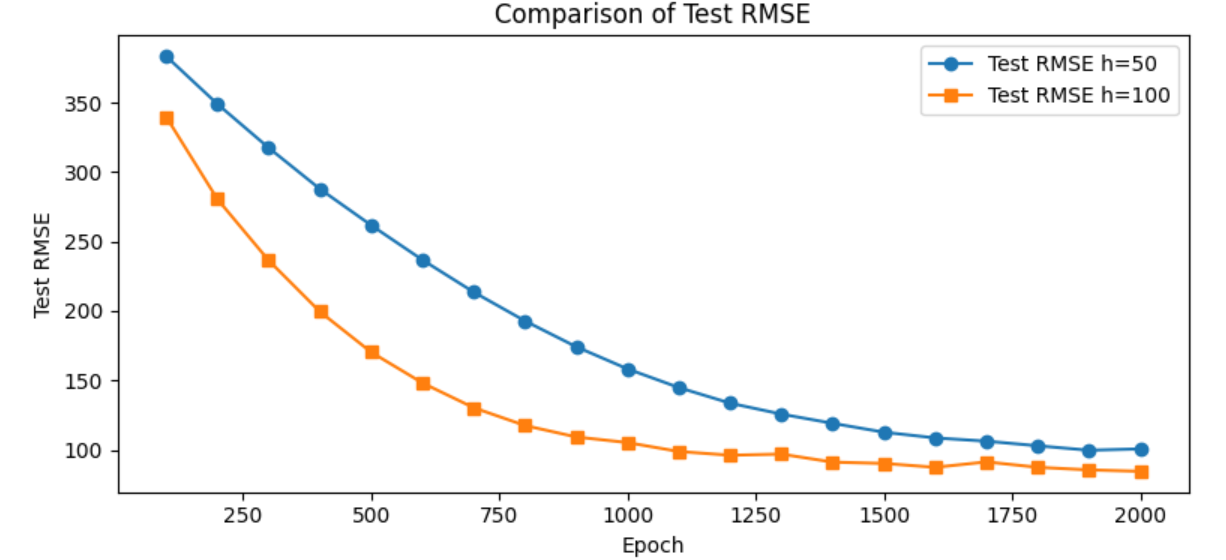

Порівняння кінцевих показників Test RMSE після 2000 епох:

hidden_size = 50 → Test RMSE ≈ 100.61

hidden_size = 100 → Test RMSE ≈ 84.47

Отже, модель з більшою кількістю прихованих одиниць (100 проти 50) демонструє суттєво кращу точність на невідомих даних (RMSE знизився майже на 16 пунктів, тобто ≈ 16 000 пасажирів).

Крім того, динаміка зниження RMSE у моделі з hidden_size=100 виглядає більш стабільною та швидшою (наприклад, вже до 600–700 епох тестова похибка опускається до ≈ 130–120, тоді як для h=50 такий рівень досягається ближче до 1400–1500 епох).